In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import pickle as pkl
import cv2

from load_data import datainfo

from tqdm import tqdm
from math import ceil

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.transform import rotate, AffineTransform, warp

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, TruncatedNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras.backend as K

In [2]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

train_pkl = "./train_data.pkl"

In [3]:
def pkl_data(filename):
    with open(filename,'rb') as f:
        X_t, y_t = pkl.load(f)
    return X_t, y_t

In [4]:
X_t, y_t = pkl_data(train_pkl)

In [5]:
assert(len(X_t) == len(y_t)),"X_train and Y_train are of different sizes"
print(len(X_t))

366320


In [6]:
print(X_t.shape)

(366320, 2)


In [7]:
X_train, X_valid, y_train, y_valid=train_test_split(X_t, y_t,test_size=0.2,random_state=7)

In [8]:
def affinetransform(image):
    transform = AffineTransform(translation=(-30,0))
    warp_image = warp(image,transform, mode="wrap")
    return warp_image

def anticlockwise_rotation(image):
    angle= random.randint(0,45)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,45)
    return rotate(image, -angle)


In [9]:
def transform(image):
    if random.random() > 0.5:
        image = affinetransform(image)
    if random.random() > 0.5:
        image = anticlockwise_rotation(image)
    if random.random() > 0.5:
        image = clockwise_rotation(image)
    return image

In [10]:
def data_generator(X_t, y_t,batch_size, isTrain = True):
    num_samples = len(X_t)
    while(True):
        for offset in range(0, num_samples, batch_size):
            x = X_t[offset:offset + batch_size]
            y = y_t[offset:offset + batch_size]
            
            X_left, X_right, y_batch = [],[],[]

            for i in range(len(x)):
                img0_path, img1_path = x[i][0], x[i][1]
                label = y[i] 
                img0 = mpimg.imread(img0_path)
                img1 = mpimg.imread(img1_path)

                if isTrain:
                    img0 = transform(img0)
                    img1 = transform(img1)
                
                img0 = np.expand_dims(img0, axis = 2)
                img1 = np.expand_dims(img1, axis = 2)

                
                X_left.append(img0)
                X_right.append(img1)
                y_batch.append(label)

            X_left, X_right, y_batch = np.array(X_left), np.array(X_right), np.array(y_batch)
            yield [X_left, X_right], y_batch

In [11]:
batch_size = 32

train_generator = data_generator(X_train,y_train, batch_size= batch_size, isTrain=True)
valid_generator = data_generator(X_valid, y_valid, batch_size = batch_size, isTrain=False)

Text(0.5, 1.0, '[1]')

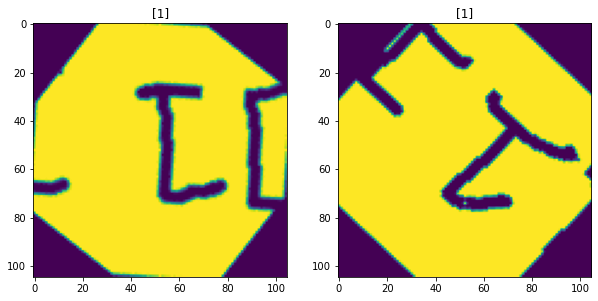

In [12]:
X_o, y_t = next(train_generator)
X_left, X_right = X_o[0], X_o[1]
for i in range(len(y_t)):
    if y_t[i] == 1:
        break

img0 = X_left[i]
img1 = X_right[i]
label = y_t[i]

img0 = np.squeeze(img0, axis = 2)
img1 = np.squeeze(img1, axis = 2)

f, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(img0)
ax[0].set_title(label)

ax[1].imshow(img1)
ax[1].set_title(label)

Text(0.5, 1.0, '[0]')

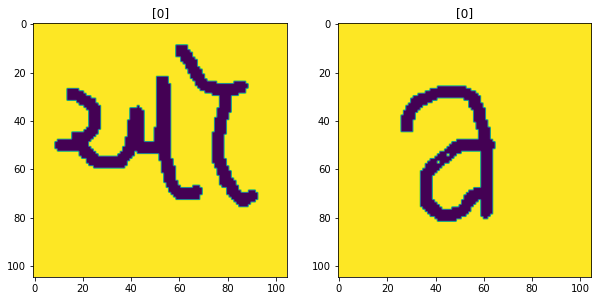

In [13]:
X_o, y_t = next(valid_generator)
X_left, X_right = X_o[0], X_o[1]
for i in range(len(y_t)):
    if y_t[i] == 0:
        break

img0 = X_left[i]
img1 = X_right[i]
label = y_t[i]

img0 = np.squeeze(img0, axis = 2)
img1 = np.squeeze(img1, axis = 2)

f, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(img0)
ax[0].set_title(label)

ax[1].imshow(img1)
ax[1].set_title(label)

In [14]:
batch_size = 32

train_generator = data_generator(X_train,y_train, batch_size= batch_size, isTrain=True)
valid_generator = data_generator(X_valid, y_valid, batch_size = batch_size, isTrain=False)

In [15]:
def plot_metric(history):
    acc, val_acc, loss, val_loss = history['accuracy'], history['val_accuracy'], history['loss'], history['val_loss']
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = "upper left")

    plt.subplot(1,2,2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc = "upper left")

In [16]:
def euclidean_dist(vect):
    x, y = vect
    sum_square = K.sum(K.square(x-y), axis = 1, keepdims = True)
    result = K.maximum(sum_square, K.epsilon())
    return result

In [17]:
def get_model():

    input_shape = (105, 105, 1)
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    convnet = Sequential()
    convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(7,7),activation='relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(4,4),activation='relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(256,(4,4),activation='relu'))
    convnet.add(Flatten())
    convnet.add(Dense(4096,activation="sigmoid"))
    #encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)

    merge_layer = Lambda(euclidean_dist)([encoded_l,encoded_r])
    prediction = Dense(1,activation='sigmoid')(merge_layer)
    model = Model(inputs=[left_input,right_input],outputs=prediction)

    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr =0.00006), metrics = ['accuracy'])
    return model


In [18]:
siamese_net = get_model()
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [19]:
siamese_net.count_params()

38947650

In [20]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = siamese_net.fit(train_generator, steps_per_epoch=ceil(len(X_train)/batch_size),
                             validation_data = valid_generator, validation_steps = ceil(len(X_valid)/batch_size), epochs = 20, verbose = True, shuffle = True, callbacks=callbacks_list)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9158/9158 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7356WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001920DD9A948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

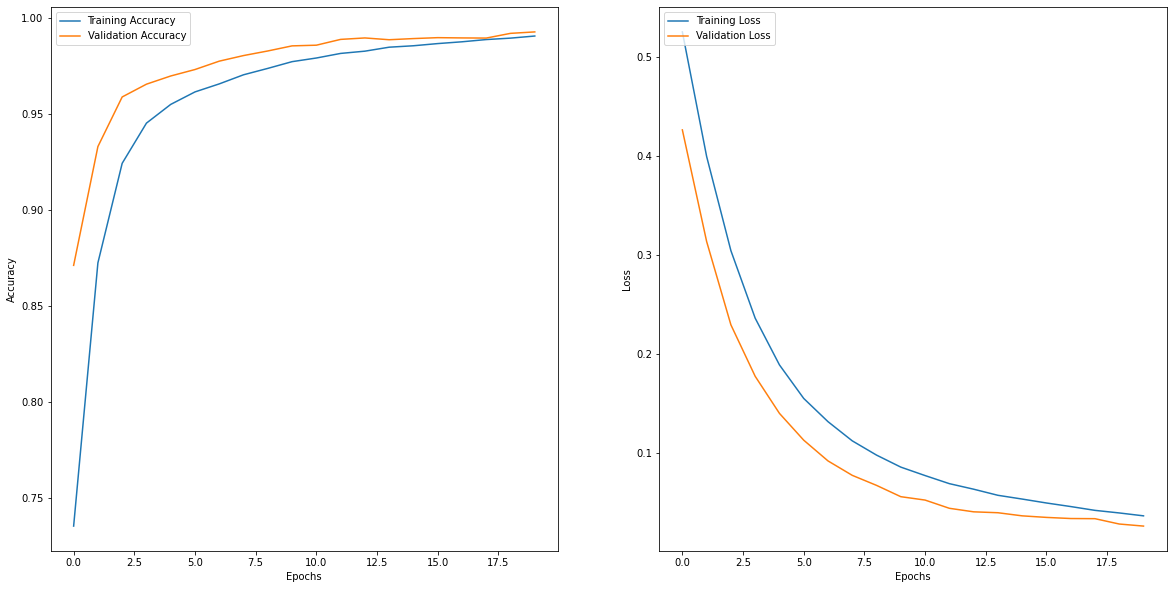

In [22]:
plot_metric(history.history)

In [42]:
X_t, y_t = pkl_data('test_data.pkl')

In [24]:
#X_t, y_t = pkl_data('test_dir_data.pkl')
test_generator = data_generator(X_t,y_t, batch_size= 1024)

In [26]:
siamese_net.load_weights('weights-improvement-20-0.99.hdf5')

In [27]:
total_batches = ceil(len(X_t)/1024)
print(total_batches)
result = 0
for i in range(total_batches):
    x_o, y_o = next(test_generator)
    result += siamese_net.evaluate(x_o, y_o, batch_size =1024)[1]
result /= total_batches

#result = siamese_net.evaluate(test_generator, batch_size = 128)
print(result * 100)

 [==============================] - 0s 0s/step - loss: 0.2678 - accuracy: 0.9092
1/1 [==============================] - 0s 997us/step - loss: 0.5598 - accuracy: 0.8670
93.53668278577376


In [50]:
X_t, y_t = pkl_data('test_dir_data.pkl')

In [29]:
def test_one_shot(model,X_left,X_right,y):
    prob = model.predict([X_left,X_right])
    if np.argmax(prob) == 0:
        return 1
    else:
        return 0

In [30]:
def load_test_batch(n_samples):
    
    correct_pred = 0
    labels = np.unique(y_t)
    label_to_idx = [np.where(y_t==label)[0] for label in labels]
    for i in tqdm(range(len(labels))):

        X_left, X_right =[],[]
        y=[]

        lbl1 = i
        label_ids = label_to_idx[i]

        #same
        id1 = random.choice(label_ids)
        id2 = random.choice(label_ids)
        img0_path = X_t[id1][0]
        img1_path = X_t[id2][0]

        img0 = mpimg.imread(img0_path)
        img1 = mpimg.imread(img1_path)

        img0 = np.expand_dims(img0, axis = 2)
        img1 = np.expand_dims(img1, axis = 2)

        X_left.append(img0)
        X_right.append(img1)
        y.append(1)

        for _ in range(n_samples):

            lbl2 = random.randint(0, len(labels)-1)
            while(lbl2 == lbl1):
                lbl2 = random.randint(0, len(labels)-1)
            id = random.choice(label_to_idx[lbl2])
            img2_path = X_t[id][0]
            img2 = mpimg.imread(img2_path)
            img2 = cv2.resize(img2, (105,105))
            img2 = np.expand_dims(img2, axis = 2)

            X_left.append(img0)
            X_right.append(img2)
            
            y.append(0)
        X_left, X_right, y = np.array(X_left), np.array(X_right), np.array(y)

        correct_pred += test_one_shot(siamese_net,X_left, X_right, y)
    return correct_pred*100/i

        

In [31]:
def one_shot_accuracy():
    accuracies = []
    #[1, 4, 5, 9, 10, 15, 16, 20]
    for i in [1, 4, 5, 9, 14, 15, 19]:
        X_left, X_right, y = load_test_batch(i) 
        acc = load_test_batch(i)
        print("\n{} shot accuracy: {} %\n".format(i,acc))
        accuracies.append(acc)
    print(accuracies)


In [32]:
one_shot_accuracy()

0%|          | 0/659 [00:00<?, ?it/s]WARNING:tensorflow:AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x0000018FDDA4D288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  0%|          | 0/659 [00:00<?, ?it/s]
1 shot accuracy: 98.78419452887537 %

  0%|          | 0/659 [00:00<?, ?it/s]
4 shot accuracy: 97.11246200607903 %

  0%|          | 0/659 [00:00<?, ?it

In [ ]:
89.8537036107511 [98.78419452887537, 94.37689969604864, 94.37689969604864, 90.27355623100304, 91.1854103343465, 85.56231003039514, 89.05775075987842, 85.56231003039514]


In [ ]:
93.53668278577376 [98.78419452887537, 97.11246200607903, 97.11246200607903, 94.98480243161094, 89.8176291793313, 92.55319148936171, 89.66565349544074]

In [52]:
from mpl_toolkits.axes_grid1 import ImageGrid
import re

100%|██████████| 20/20 [00:00<00:00, 2874.88it/s]


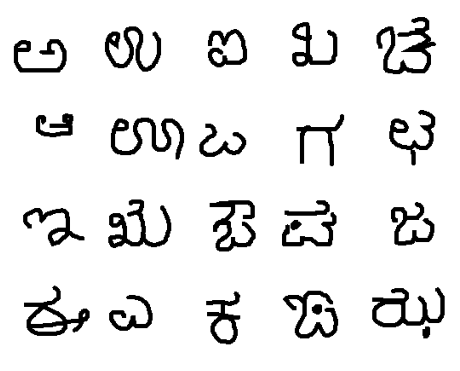

In [115]:
def visualize_alphabets(alphabet= None, character = False, n = 20):
    labels = np.unique(y_t)
    labels = [label for label in labels if alphabet in str(label)]
    label_to_idx = [np.where(y_t==label)[0] for label in labels]
    img_matrix = []
    X_p = []
    for i in tqdm(range(1,n+1)):
        if character == False:
            label_ids = label_to_idx[i-1]
            id1 = random.choice(label_ids)
        else:
            id1 = label_to_idx[0][i-1]
        
        img0_path = X_t[id1][0]
        img0 = mpimg.imread(img0_path)
        X_p.append(img0)
        if i%4==0:
            X_p =np.vstack(X_p)
            img_matrix.append(X_p)
            X_p = []
    img_matrix = np.asarray(img_matrix)
    img_matrix = np.hstack(img_matrix)
    #imgs = []
    #imgs.append(img_matrix)
    #imgs =np.hstack(imgs).astype('float64')
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img_matrix, cmap = 'gray')
    
alphabet = 'Kannada'
visualize_alphabets(alphabet, n = 20)            


100%|██████████| 20/20 [00:00<00:00, 2235.83it/s]


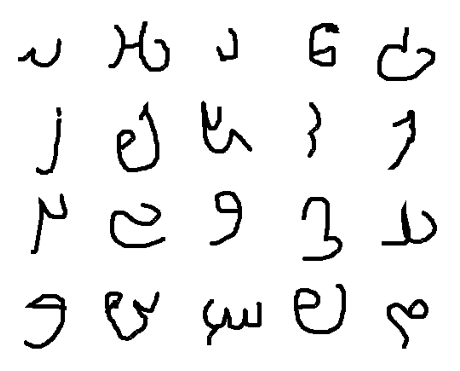

In [116]:
alphabet = 'Avesta'
visualize_alphabets(alphabet, n = 20) 

100%|██████████| 20/20 [00:00<00:00, 2228.11it/s]


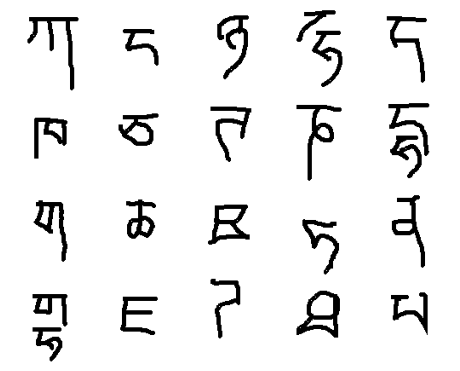

In [117]:
alphabet = 'Tibetan'
visualize_alphabets(alphabet, n = 20) 

100%|██████████| 20/20 [00:00<00:00, 2005.74it/s]


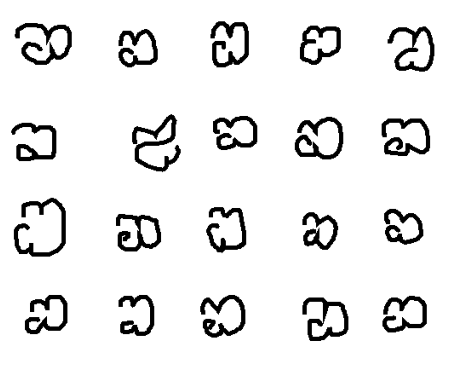

In [124]:
alphabet = 'Kannada_character09'
visualize_alphabets(alphabet =alphabet, character = True, n = 20) 

In [ ]:
fig = plt.figure(figsize=(8., 8.))
im1, im2, im3, im4 = X_p[0], X_p[1],X_p[2],X_p[3]
grid = ImageGrid(fig, 122,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')

plt.show()

In [119]:
alphabet ='Kannada_character01'
labels = np.unique(y_t)
labels = [label for label in labels if alphabet in str(label)]
label_to_idx = [np.where(y_t==label)[0] for label in labels]

In [120]:
label_to_idx[0]

array([4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810,
       4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819], dtype=int64)

In [148]:
def visualize_n_way(n_samples):
    labels = np.unique(y_t)
    label_to_idx = [np.where(y_t==label)[0] for label in labels]
    for i in tqdm(range(len(labels))):

        X_p = []
        img_matrix = []
        lbl1 = random.choice(range(len(labels)))
        label_ids = label_to_idx[lbl1]

        id1 = random.choice(label_ids)
        id2 = random.choice(label_ids)
        img0_path = X_t[id1][0]
        img1_path = X_t[id2][0]

        img0 = mpimg.imread(img0_path)
        img1 = mpimg.imread(img1_path)

        X_p.append(img1)
       
        for _ in range(n_samples-1):

            lbl2 = random.randint(0, len(labels)-1)
            while(lbl2 == lbl1):
                lbl2 = random.randint(0, len(labels)-1)
            id = random.choice(label_to_idx[lbl2])
            img2_path = X_t[id][0]
            img2 = mpimg.imread(img2_path)
            X_p.append(img2)
            if len(X_p) == 2:
                X_p =np.vstack(X_p)
                img_matrix.append(X_p)
                X_p = []

        img_matrix = np.asarray(img_matrix)
        img_matrix = np.hstack(img_matrix)
        return img0, img_matrix
            

0%|          | 0/659 [00:00<?, ?it/s]


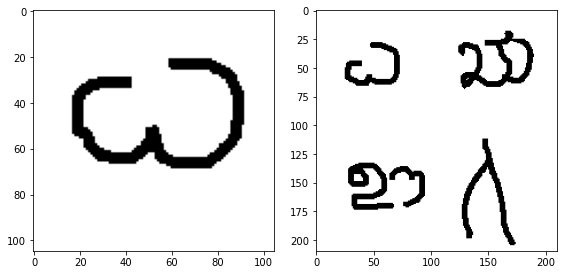

In [149]:
n_samples = 4
img0, img_matrix = visualize_n_way(n_samples)

f, ax=  plt.subplots(1,2, figsize = (8,8))
f.tight_layout()
ax[0].imshow(img0, cmap = 'gray')
ax[1].imshow(img_matrix, cmap = 'gray')